# Recommendation

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
%matplotlib inline
pd.set_option('display.max_columns', None)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from scipy.sparse import hstack, vstack, coo_matrix

In [20]:
loans = pd.read_csv(r'Kiva dataset/loans.csv')
lender_mapping = pd.read_csv('Kiva dataset/loans_lenders.csv')
print(loans.shape, lender_mapping.shape)

(2019262, 34) (1966994, 2)


# Data preprocessing

In [21]:
# Convert to dates for date columns
for c in [c for c in loans.columns if re.search('\w+TIME', c)]:
    loans[c] = pd.to_datetime(loans[c])

# Filter to loans posted in 2019 and 2020
loans = loans[(loans.POSTED_TIME >= '2019-1-1') & (loans.POSTED_TIME <= '2020-3-31')]

# Change to a list of lenders without duplicates
lender_mapping['lenders_list'] = lender_mapping.LENDERS.\
                                 apply(lambda x: list(set([x.strip() for x in x.split(',')])))

# Map list of lenders to loans
loans['lender'] = loans.LOAN_ID.map(lender_mapping[['LOAN_ID', 'lenders_list']]\
                               .set_index('LOAN_ID')\
                               .squeeze())

# Calculate funding ratio
loans['funding_ratio'] = loans.FUNDED_AMOUNT / loans.LOAN_AMOUNT
loans['fully_funded'] = loans.funding_ratio >= 1

# Denote train and test: 2019 for train and 2020 for test
loans['window'] = np.where(loans.POSTED_TIME >= '2020-1-1', 'test', 'train')

# Gender - Mixed if consist of both female and male
loans['female'] = loans.BORROWER_GENDERS.str.contains('female') * 1
loans['male'] = loans.BORROWER_GENDERS.str.contains(r'^male') * 1
loans['gender_mixed']= (loans.male & loans.female) * 1

# Gender - Otherwise, either male only or female only
loans['male_only'] = np.where(loans.gender_mixed, 0, loans.male)
loans['female_only'] = np.where(loans.gender_mixed, 0, loans.female)

# Map continents
country_codes = pd.read_csv('country-and-continent-codes-list-csv.csv')
country_codes = country_codes[['Two_Letter_Country_Code', 'Continent_Name']].drop_duplicates(subset='Two_Letter_Country_Code')
country_codes = country_codes.set_index('Two_Letter_Country_Code').squeeze()
loans['continent'] = loans.COUNTRY_CODE.map(country_codes)

print('Loan dataframe shape: ', loans.shape)

# Expand lender into a row per lender-loan pairing
loan_lender = loans.explode('lender')
print('Paired loan lender dataframe shape: ', loan_lender.shape)

Loan dataframe shape:  (267768, 44)
Paired loan lender dataframe shape:  (4393373, 44)


# Get test lenders

The code below counts the number of loans for each user which are:
- "under_funded_train": Underfunded loans in 2019
- "under_funded_test": Underfunded loans in 2020 Q1
- "fully_funded_train": Fully funded loans in 2019
- "fully_funded_test": Fully funded loans in 2020 Q1

The intention is to use the users' loans in 2019 to recommend similar loans within all underfunded loans in 2020 Q1 and test this by seeing which 2020 Q1 underfunded loans were truly donated to.

In [22]:
loan_lender['counter'] = 1
lender_x_ufloans = loan_lender.pivot_table(index='lender', 
                                            columns=['fully_funded', 'window'], 
                                            values='counter',
                                            aggfunc='sum').fillna(0)

lender_x_ufloans = pd.DataFrame(lender_x_ufloans.values, index = lender_x_ufloans.index,
                                 columns = ['under_funded_test', 'under_funded_train',
                                            'fully_funded_test', 'fully_funded_train'])

lender_x_ufloans['total_loans'] = lender_x_ufloans.sum(axis=1)
lender_x_ufloans['total_2019'] = lender_x_ufloans.under_funded_train + lender_x_ufloans.fully_funded_train

# Show top supporters of underfunded loans with more than 100 loans

lender_x_ufloans[lender_x_ufloans.total_loans >= 100]\
.sort_values('under_funded_test', ascending=False).head(20)

,under_funded_test,under_funded_train,fully_funded_test,fully_funded_train,total_loans,total_2019
lender,,,,,,
kent3290,92.0,190.0,244.0,1026.0,1552.0,1216.0
themissionbeltco,75.0,4320.0,6005.0,33146.0,43546.0,37466.0
gooddogg1,72.0,2229.0,8661.0,38862.0,49824.0,41091.0
trolltech4460,52.0,1848.0,4982.0,14101.0,20983.0,15949.0
henry1547,31.0,5097.0,109.0,282.0,5519.0,5379.0
barbara5610,31.0,1347.0,1197.0,3658.0,6233.0,5005.0
rene3075,22.0,1152.0,3428.0,13428.0,18030.0,14580.0
cliff5639,20.0,130.0,711.0,1938.0,2799.0,2068.0
anonymous5138,19.0,1872.0,6304.0,19459.0,27654.0,21331.0


Not many lenders have done many donations to underfunded loans in 2020 Q1, but these lenders will be selected for testing the recommendation model.

In [23]:
test_lenders = lender_x_ufloans[lender_x_ufloans['under_funded_test']>10].index.tolist()

In [24]:
len(test_lenders)

14

# Content filtering without diversity

In [25]:
# Define data before cutoff as train, after cutoff as test
cut_off_date = '2019-12-31'

# Define columns to use for cosine similarity calculations
numerical_cols = ['gender_mixed', 'male_only', 'female_only']
categorical_cols = ['ACTIVITY_NAME', 'SECTOR_NAME', 'continent', 'COUNTRY_CODE', 'ORIGINAL_LANGUAGE']

def get_underfunded_loans(numerical_features, categorical_features, cut_off_date):
    
    '''Get potential underfunded loans that is to be recommended'''
    
    cond1 = loans.fully_funded == 0
    cond2 = loans.POSTED_TIME >= cut_off_date
    underfunded = loans[cond1 & cond2]
    underfunded = underfunded[numerical_features + categorical_features].dropna()

    return underfunded
    
def get_past_loans(user, cut_off_date, numerical_features, categorical_features):
    
    '''Get the loans user has previously invested in'''
    
    past_loans = loan_lender[(loan_lender.lender == user) & (loan_lender.POSTED_TIME <= cut_off_date)]
    past_loans = past_loans[numerical_features + categorical_features].dropna()
    past_loans = pd.get_dummies(past_loans, columns=categorical_cols)
    past_loans = pd.DataFrame(past_loans.mean()).T
    
    return past_loans

def get_similarity_matrix(user, categorical_features, underfunded, past_loans):

    '''Calculate cosine similarities for user loans and underfunded loans'''

    # Encode underfunded loans
    underfunded = pd.get_dummies(underfunded, columns=categorical_cols)

    # Stack with all possible underfunded loans after cut-off
    input_loans = pd.concat([past_loans, underfunded], axis=0).dropna(axis=1)

    # PCA to lower dimension space
    pca = PCA(n_components=0.95)
    input_loans = pca.fit_transform(input_loans)

    cosine_similarities = cosine_similarity(input_loans, input_loans)

    return cosine_similarities

def get_recommendations(cs_matrix, underfunded, n_recommendations):

    '''Return a dataframe of the recommended loans'''
    
    similarity_scores = cs_matrix[:1, 1:]

    # Get n top similar loans according to user portfolio
    idx = (-similarity_scores).argsort()[0][:n_recommendations]
    recommended_loans = underfunded.iloc[idx]

    return recommended_loans

def did_it_match(user, cut_off_date, loans, recommended_loans):
    
    '''Return a dataframe of true matches'''
    
    # Retrieve loan IDs
    recommended_loans = recommended_loans.merge(loans['LOAN_ID'], left_index=True, right_index=True)
    
    cond1 = loan_lender.lender == user
    cond2 = loan_lender.POSTED_TIME >= cut_off_date
    cond3 = loan_lender.fully_funded == 0
    underfunded_for_user = loan_lender[cond1 & cond2 & cond3]

    # Did we get back any loans that he really invested in?
    matched_loans = underfunded_for_user[underfunded_for_user.LOAN_ID.isin(recommended_loans.LOAN_ID)]
    
    recommended_loans['hit'] = recommended_loans['LOAN_ID'].isin(underfunded_for_user.LOAN_ID)
    
    return matched_loans, recommended_loans

In [26]:
user_matches = []
recommendations = []

for user in tqdm(test_lenders):
    
    past_loans = get_past_loans(user, '2019-12-31', numerical_cols, categorical_cols)
    
    underfunded = get_underfunded_loans(numerical_cols, categorical_cols, '2019-12-31')
    cs_matrix = get_similarity_matrix(user, categorical_cols, underfunded, past_loans)
    
    underfunded = get_underfunded_loans(numerical_cols, categorical_cols, '2019-12-31')
    recommended_loans = get_recommendations(cs_matrix, underfunded, 10)
    l = len(did_it_match(user, '2019-12-31', loans, recommended_loans)[0])
    user_matches.append((user, l))
    recommendations.append(recommended_loans)
    
user_matches

100%|██████████| 14/14 [00:13<00:00,  1.01it/s]


[('am8748', 2),
 ('amirali5409', 1),
 ('anish7115', 0),
 ('anonymous5138', 3),
 ('barbara5610', 5),
 ('cliff5639', 0),
 ('gooddogg1', 0),
 ('henry1547', 0),
 ('kent3290', 5),
 ('rene3075', 0),
 ('sharon047', 1),
 ('themissionbeltco', 0),
 ('tristan4920', 1),
 ('trolltech4460', 1)]

In [28]:
user = 'barbara5610'
numerical_features = numerical_cols
categorical_features = categorical_cols

past_loans = loan_lender[(loan_lender.lender == user) & (loan_lender.POSTED_TIME <= cut_off_date)]
past_loans = past_loans[numerical_features + categorical_features].dropna()
past_loans = pd.get_dummies(past_loans, columns=categorical_cols)
past_loans.shape

(4990, 202)

In [29]:
# Average of attributes of barbara5610's past loans
get_past_loans('barbara5610', cut_off_date, numerical_cols, categorical_cols)

,gender_mixed,male_only,female_only,ACTIVITY_NAME_Agriculture,ACTIVITY_NAME_Animal Sales,ACTIVITY_NAME_Aquaculture,ACTIVITY_NAME_Auto Repair,ACTIVITY_NAME_Bakery,ACTIVITY_NAME_Barber Shop,ACTIVITY_NAME_Beauty Salon,ACTIVITY_NAME_Beverages,ACTIVITY_NAME_Blacksmith,ACTIVITY_NAME_Bookstore,ACTIVITY_NAME_Bricks,ACTIVITY_NAME_Butcher Shop,ACTIVITY_NAME_Cafe,ACTIVITY_NAME_Carpentry,ACTIVITY_NAME_Catering,ACTIVITY_NAME_Cattle,ACTIVITY_NAME_Cement,ACTIVITY_NAME_Cereals,ACTIVITY_NAME_Charcoal Sales,ACTIVITY_NAME_Cleaning Services,ACTIVITY_NAME_Cloth & Dressmaking Supplies,ACTIVITY_NAME_Clothing,ACTIVITY_NAME_Clothing Sales,ACTIVITY_NAME_Cobbler,ACTIVITY_NAME_Computer,ACTIVITY_NAME_Computers,ACTIVITY_NAME_Construction,ACTIVITY_NAME_Construction Supplies,ACTIVITY_NAME_Consumer Goods,ACTIVITY_NAME_Cosmetics Sales,ACTIVITY_NAME_Crafts,ACTIVITY_NAME_Dairy,ACTIVITY_NAME_Dental,ACTIVITY_NAME_Education provider,ACTIVITY_NAME_Electrical Goods,ACTIVITY_NAME_Electronics Repair,ACTIVITY_NAME_Electronics Sales,ACTIVITY_NAME_Embroidery,ACTIVITY_NAME_Event Planning,ACTIVITY_NAME_Farm Supplies,ACTIVITY_NAME_Farming,ACTIVITY_NAME_Fish Selling,ACTIVITY_NAME_Fishing,ACTIVITY_NAME_Florist,ACTIVITY_NAME_Food,ACTIVITY_NAME_Food Market,ACTIVITY_NAME_Food Production/Sales,ACTIVITY_NAME_Food Stall,ACTIVITY_NAME_Fruits & Vegetables,ACTIVITY_NAME_Fuel/Firewood,ACTIVITY_NAME_Furniture Making,ACTIVITY_NAME_General Store,ACTIVITY_NAME_Goods Distribution,ACTIVITY_NAME_Grocery Store,ACTIVITY_NAME_Hardware,ACTIVITY_NAME_Health,ACTIVITY_NAME_Higher education costs,ACTIVITY_NAME_Home Appliances,ACTIVITY_NAME_Home Energy,ACTIVITY_NAME_Home Products Sales,ACTIVITY_NAME_Hotel,ACTIVITY_NAME_Internet Cafe,ACTIVITY_NAME_Jewelry,ACTIVITY_NAME_Knitting,ACTIVITY_NAME_Laundry,ACTIVITY_NAME_Liquor Store / Off-License,ACTIVITY_NAME_Livestock,ACTIVITY_NAME_Machinery Rental,ACTIVITY_NAME_Manufacturing,ACTIVITY_NAME_Metal Shop,ACTIVITY_NAME_Milk Sales,ACTIVITY_NAME_Mobile Phones,ACTIVITY_NAME_Mobile Transactions,ACTIVITY_NAME_Motorcycle Repair,ACTIVITY_NAME_Motorcycle Transport,ACTIVITY_NAME_Office Supplies,ACTIVITY_NAME_Perfumes,ACTIVITY_NAME_Personal Care Products,ACTIVITY_NAME_Personal Expenses,ACTIVITY_NAME_Personal Housing Expenses,ACTIVITY_NAME_Personal Medical Expenses,ACTIVITY_NAME_Personal Products Sales,ACTIVITY_NAME_Pharmacy,ACTIVITY_NAME_Phone Accessories,ACTIVITY_NAME_Phone Use Sales,ACTIVITY_NAME_Photography,ACTIVITY_NAME_Pigs,ACTIVITY_NAME_Plastics Sales,ACTIVITY_NAME_Poultry,ACTIVITY_NAME_Primary/secondary school costs,ACTIVITY_NAME_Printing,ACTIVITY_NAME_Property,ACTIVITY_NAME_Pub,ACTIVITY_NAME_Quarrying,ACTIVITY_NAME_Recycling,ACTIVITY_NAME_Restaurant,ACTIVITY_NAME_Retail,ACTIVITY_NAME_Rickshaw,ACTIVITY_NAME_Services,ACTIVITY_NAME_Sewing,ACTIVITY_NAME_Shoe Sales,ACTIVITY_NAME_Spare Parts,ACTIVITY_NAME_Tailoring,ACTIVITY_NAME_Taxi,ACTIVITY_NAME_Technology,ACTIVITY_NAME_Textiles,ACTIVITY_NAME_Timber Sales,ACTIVITY_NAME_Tourism,ACTIVITY_NAME_Transportation,ACTIVITY_NAME_Upholstery,ACTIVITY_NAME_Used Clothing,ACTIVITY_NAME_Used Shoes,ACTIVITY_NAME_Vehicle,ACTIVITY_NAME_Vehicle Repairs,ACTIVITY_NAME_Water Distribution,ACTIVITY_NAME_Weaving,ACTIVITY_NAME_Wedding Expenses,ACTIVITY_NAME_Wholesale,SECTOR_NAME_Agriculture,SECTOR_NAME_Arts,SECTOR_NAME_Clothing,SECTOR_NAME_Construction,SECTOR_NAME_Education,SECTOR_NAME_Food,SECTOR_NAME_Health,SECTOR_NAME_Housing,SECTOR_NAME_Manufacturing,SECTOR_NAME_Personal Use,SECTOR_NAME_Retail,SECTOR_NAME_Services,SECTOR_NAME_Transportation,SECTOR_NAME_Wholesale,continent_Africa,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,COUNTRY_CODE_AL,COUNTRY_CODE_AM,COUNTRY_CODE_BF,COUNTRY_CODE_BO,COUNTRY_CODE_BR,COUNTRY_CODE_CD,COUNTRY_CODE_CM,COUNTRY_CODE_CO,COUNTRY_CODE_CR,COUNTRY_CODE_DO,COUNTRY_CODE_EC,COUNTRY_CODE_EG,COUNTRY_CODE_FJ,COUNTRY_CODE_GE,COUNTRY_CODE_GH,COUNTRY_CODE_GT,COUNTRY_CODE_HN,COUNTRY_CODE_HT,COUNTRY_CODE_IN,COUNTRY_CODE_JO,COUNTRY_CODE_KE,COUNTRY_CODE_KG,COUNTRY_CODE_KH,COUNT

In [30]:
# Recommendation loans attributes for barbara5610
recommendations[4]

,gender_mixed,male_only,female_only,ACTIVITY_NAME,SECTOR_NAME,continent,COUNTRY_CODE,ORIGINAL_LANGUAGE
248125,0,0,1,Farming,Agriculture,Africa,KE,English
167917,0,0,1,Farming,Agriculture,Africa,KE,English
247489,0,0,1,Farming,Agriculture,Africa,KE,English
330109,0,0,1,Farming,Agriculture,Africa,KE,English
1510874,0,0,1,Farming,Agriculture,Africa,KE,English
1292506,0,0,1,Farming,Agriculture,Africa,KE,English
1253174,0,0,1,Farming,Agriculture,Africa,KE,English
1812006,0,0,1,Farming,Agriculture,Africa,KE,English
1177788,0,0,1,Farming,Agriculture,Africa,KE,English
1850877,0,0,1,Farming,Agriculture,Africa,KE,English


In [31]:
# Loans recommended to barbara5610
loans.loc[recommendations[4].index]

,LOAN_ID,LOAN_NAME,ORIGINAL_LANGUAGE,DESCRIPTION,DESCRIPTION_TRANSLATED,FUNDED_AMOUNT,LOAN_AMOUNT,STATUS,IMAGE_ID,VIDEO_ID,ACTIVITY_NAME,SECTOR_NAME,LOAN_USE,COUNTRY_CODE,COUNTRY_NAME,TOWN_NAME,CURRENCY_POLICY,CURRENCY_EXCHANGE_COVERAGE_RATE,CURRENCY,PARTNER_ID,POSTED_TIME,PLANNED_EXPIRATION_TIME,DISBURSE_TIME,RAISED_TIME,LENDER_TERM,NUM_LENDERS_TOTAL,NUM_JOURNAL_ENTRIES,NUM_BULK_ENTRIES,TAGS,BORROWER_NAMES,BORROWER_GENDERS,BORROWER_PICTURED,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,lender,funding_ratio,fully_funded,window,female,male,gender_mixed,male_only,female_only,continent
248125,1912203,Meshack's Group,English,Meshack is 29 years old and has 2 children. He...,Meshack is 29 years old and has 2 children. He...,150.0,1150.0,expired,3354489.0,NaN,Farming,Agriculture,to purchase hybrid seeds and fertilizer to imp...,KE,Kenya,Teso,shared,0.1,KES,202.0,2020-01-15 12:28:32+00:00,2020-02-15 07:10:08+00:00,2020-01-28 08:00:00+00:00,NaT,12.0,5,1,1,"#Sustainable Ag, #Repeat Borrower, #Technology...","Jane, Pamela , Simon, Joan, Francisca, Grace, ...","female, female, male, female, female, female, ...","true, true, true, true, true, true, true, true...",bullet,field_partner,"[barbara5610, jouko1940, kent3290]",0.130435,False,test,1,0,0,0,1,Africa
167917,1912286,Maurice's Group,English,"Pictured above is Maurice, who, as a group lea...","Pictured above is Maurice, who, as a group lea...",50.0,800.0,expired,3357419.0,NaN,Farming,Agriculture,to buy cost efficient maize seeds and fertiliz...,KE,Kenya,Kakamega North,shared,0.1,KES,202.0,2020-01-15 13:42:58+00:00,2020-02-15 14:10:18+00:00,2020-01-28 08:00:00+00:00,NaT,12.0,2,1,1,"#Eco-friendly, #Schooling, #Parent, #Vegan, #R...","Alice, Maurice, Patrick, Rose, Nickson, Silvan...","female, male, male, female, male, male, male, ...","true, true, true, true, true, true, true, true...",bullet,field_partner,[erick],0.062500,False,test,1,0,0,0,1,Africa
247489,1912207,Jane's Group,English,"Jane, pictured above, has been a farmer for mo...","Jane, pictured above, has been a farmer for mo...",75.0,625.0,expired,3355597.0,NaN,Farming,Agriculture,to purchase hybrid seeds and fertilizer for th...,KE,Kenya,Kakamega North,shared,0.1,KES,202.0,2020-01-15 12:33:22+00:00,2020-02-15 07:10:08+00:00,2020-01-28 08:00:00+00:00,NaT,12.0,3,1,1,"#Sustainable Ag, #Eco-friendly, #Technology, #...","Sara, Virginia, Beatrice, Magilita, Bonface, J...","female, female, female, female, male, female, ...","true, true, true, true, true, true, true, true...",bullet,field_partner,"[barbara5610, jouko1940]",0.120000,False,test,1,0,0,0,1,Africa
330109,1912788,Gabriel's Group,English,"Gabriel, pictured above, has been a farmer for...","Gabriel, pictured above, has been a farmer for...",150.0,700.0,expired,3358071.0,NaN,Farming,Agriculture,to purchase hybrid seeds and fertilizer for ma...,KE,Kenya,Alego,shared,0.1,KES,202.0,2020-01-16 08:52:50+00:00,2020-02-16 01:30:09+00:00,2020-01-28 08:00:00+00:00,NaT,12.0,6,1,1,"#Technology, #Eco-friendly, #Vegan, #Elderly, ...","INVIOLETA, ALICE, ALICE, JENIFA, LILIAN, FRANS...","female, female, female, female, female, female...","true, true, true, true, true, true, true, true...",bullet,field_partner,"[barbara5610, kent3290, julie81547454, tom4058...",0.214286,False,test,1,0,0,0,1,Africa
1510874,1921159,Sixtus' Group,English,"Sixtus, pictured above, has been a farmer for ...","Sixtus, pictured above, has been a farmer for ...",375.0,850.0,expired,3359715.0,NaN,Farming,Agriculture,to purchase hybrid seeds and fertilizer for th...,KE,Kenya,Teso,shared,0.1,KES,202.0,2020-01-31 12:27:58+00:00,2020-03-16 21:10:09+00:00,2020-01-28 08:00:00+00:00,NaT,12.0,13,1,1,"#Eco-friendly, #Sustainable Ag, #Elderly, #Rep...","Genefefa, Anna, Sixtus, Rose, Anna , Mildred, ...","female, female, male, female, female, female, ...","true, true, true, true, true, true, true, true...",bullet,field_partner,"[sean3922, hetta2048, paul5436, trolltech4460,...",0.441176,False,test,1,0,0,0,1,Africa
1292506,1912787,Radigund

# Content filtering with diversity based on Maximal Marginal Relevance

1. Recommend one loan with highest similarity with user profile
2. Add loan to recommended list
3. Remove loan from underfunded basket
4. Calculate similarity of each loan in underfunded basket with loan already in recommended list
5. Weight and deduct this similarity from the similarity scores with user profile
6. Rank and add the next one to the recommended list, remove this loan from underfunded basket
7. Repeat from step 4 onwards

In [32]:
def mmr_approach(user, numerical_cols, categorical_cols, underfunded, weight=0.3):

    ## Round 1

    # Get top ranking loan

    past_loans = get_past_loans(user, '2019-12-31', numerical_cols, categorical_cols)

    cs_matrix = get_similarity_matrix(user, categorical_cols, underfunded, past_loans)

    recommended_loans = get_recommendations(cs_matrix, underfunded, 10)

    # Store top ranking loan in a dataframe
    selected = recommended_loans[:1]

    # Remove selected loan from underfunded
    underfunded_ = underfunded.drop(selected.index, axis=0)

    ## Round 2 - 10
    for i in np.arange(2, 11):

        n_selected = len(selected)

        # Calculate the similarity with the selected
        new_input = pd.get_dummies(pd.concat([selected, underfunded_], axis=0), columns=categorical_cols)
        pca = PCA(n_components=0.95)
        new_input = pca.fit_transform(new_input)       
        similarities_w_selected = cosine_similarity(new_input, new_input)[:n_selected, n_selected:]
        similarities_w_selected = np.max(similarities_w_selected, axis=0)

        # Calculate the similarity with user profile
        new_input = pd.concat([past_loans.dropna(), pd.get_dummies(underfunded_.dropna(), columns=categorical_cols)], axis=0)
        new_input = new_input.dropna(axis=1)
        pca = PCA(n_components=0.95)
        new_input = pca.fit_transform(new_input)  
        similarities_w_user_profile = cosine_similarity(new_input, new_input)[:1, 1:]

        # Difference similarity with user profile with similarity with selected
        new_similarities = similarities_w_user_profile - weight * similarities_w_selected

        # Store next top ranking loan in the same dataframe
        idx = np.argsort(-new_similarities)[0][0]
        selected = pd.concat([selected, underfunded_.iloc[[idx]]], axis=0)

        # Remove selected loans from underfunded
        underfunded_ = underfunded_.drop(selected.index[-1], axis=0)
        
    return selected

In [33]:
results = []
selecteds = []
recommendations = []
num_of_hits = 0

for user in tqdm(test_lenders):
    selected = mmr_approach(user, numerical_cols, categorical_cols, underfunded, 0.5)
    selecteds.append(selected)
    
    l = len(did_it_match(user, cut_off_date, loans, selected)[0])
    num_of_hits += l
    results.append((user, l))
    
    recommendations.append(did_it_match(user, cut_off_date, loans, selected)[1])
    
print(num_of_hits)
results

100%|██████████| 14/14 [00:25<00:00,  1.81s/it]

23


[('am8748', 3),
 ('amirali5409', 0),
 ('anish7115', 0),
 ('anonymous5138', 2),
 ('barbara5610', 4),
 ('cliff5639', 0),
 ('gooddogg1', 0),
 ('henry1547', 1),
 ('kent3290', 6),
 ('rene3075', 2),
 ('sharon047', 1),
 ('themissionbeltco', 0),
 ('tristan4920', 1),
 ('trolltech4460', 3)]

In [34]:
# Average of attributes of barbara5610's past loans now with MMR
recommendations[4]

,gender_mixed,male_only,female_only,ACTIVITY_NAME,SECTOR_NAME,continent,COUNTRY_CODE,ORIGINAL_LANGUAGE,LOAN_ID,hit
248125,0,0,1,Farming,Agriculture,Africa,KE,English,1912203,True
1993606,0,0,1,Retail,Retail,Asia,JO,English,1947390,False
1885190,0,0,1,Beverages,Food,Africa,UG,English,1912689,False
1395194,0,0,1,General Store,Retail,Africa,GH,English,1930221,False
1138837,0,0,1,Shoe Sales,Retail,Africa,KE,English,1931004,False
1086756,1,0,0,Livestock,Agriculture,Africa,UG,English,1912840,True
1937221,0,0,1,Arts,Arts,North America,US,English,1932056,False
746311,0,1,0,Food,Food,Asia,JO,English,1946676,False
160032,0,0,1,Farming,Agriculture,Africa,KE,English,1912189,True
247489,0,0,1,Farming,Agriculture,Africa,KE,English,1912207,True


In [35]:
# Loans recommended to barbara5610 now with MMR
selecteds[4]

,gender_mixed,male_only,female_only,ACTIVITY_NAME,SECTOR_NAME,continent,COUNTRY_CODE,ORIGINAL_LANGUAGE
248125,0,0,1,Farming,Agriculture,Africa,KE,English
1993606,0,0,1,Retail,Retail,Asia,JO,English
1885190,0,0,1,Beverages,Food,Africa,UG,English
1395194,0,0,1,General Store,Retail,Africa,GH,English
1138837,0,0,1,Shoe Sales,Retail,Africa,KE,English
1086756,1,0,0,Livestock,Agriculture,Africa,UG,English
1937221,0,0,1,Arts,Arts,North America,US,English
746311,0,1,0,Food,Food,Asia,JO,English
160032,0,0,1,Farming,Agriculture,Africa,KE,English
247489,0,0,1,Farming,Agriculture,Africa,KE,English


In [41]:
# Get loan IDs of selected loans for barbara5610
loans.loc[selecteds[4].index].LOAN_ID

248125     1912203
1993606    1947390
1885190    1912689
1395194    1930221
1138837    1931004
1086756    1912840
1937221    1932056
746311     1946676
160032     1912189
247489     1912207
Name: LOAN_ID, dtype: int64

## Parameter tuning on penalty weights

In [42]:
results = {'weight': [],
           'number_of_hits': []}

for i in tqdm(np.linspace(0, 0.9, 10)):
    
    num_of_hits = 0

    for user in test_lenders:
        selected = mmr_approach(user, numerical_cols, categorical_cols, underfunded, weight=i)

        l = len(did_it_match(user, cut_off_date, loans, selected)[0])
        num_of_hits += l

    results['weight'].append(i)
    results['number_of_hits'].append(num_of_hits)
    
results = pd.DataFrame(results)
results.weight = results.weight.round(1)

100%|██████████| 10/10 [03:15<00:00, 19.52s/it]


In [43]:
results.set_index('weight')

,number_of_hits
weight,
0.0,19
0.1,18
0.2,16
0.3,20
0.4,21
0.5,23
0.6,21
0.7,21
0.8,22


What weights are optimum that can get the highest number of hits?

Text(0.5, 0, 'Weight for intra-recommendation list similarity')

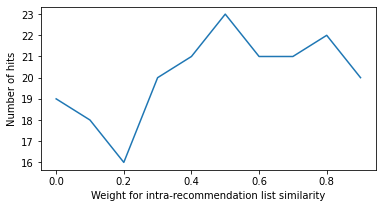

In [44]:
fig, ax = plt.subplots(figsize=(6,3))
sns.lineplot(x='weight', y='number_of_hits', data=results, ax=ax)
ax.set_ylabel('Number of hits')
ax.set_xlabel('Weight for intra-recommendation list similarity')

# Content filtering with NLP

In [45]:
# Define data before cutoff as train, after cutoff as test
cut_off_date = '2019-12-31'

# Define columns to use for cosine similarity calculations
numerical_cols = ['gender_mixed', 'male_only', 'female_only']
categorical_cols = ['ACTIVITY_NAME', 'SECTOR_NAME', 'continent', 'COUNTRY_CODE', 'ORIGINAL_LANGUAGE']
nlp_cols = ['DESCRIPTION_TRANSLATED']

# Get underfunded loans
cond1 = loans.fully_funded == 0
cond2 = loans.POSTED_TIME > cut_off_date
underfunded = loans[cond1 & cond2]
underfunded = underfunded[numerical_cols + categorical_cols + ['DESCRIPTION_TRANSLATED']].dropna()
print(underfunded.shape)

loan_lender_pre_cutoff = loan_lender[loan_lender.POSTED_TIME <= cut_off_date]

results = []

num_of_hits = 0

for user in tqdm(test_lenders):
        
    past_loans = loan_lender_pre_cutoff[(loan_lender_pre_cutoff.lender == user)]
    past_loans = past_loans[numerical_cols + categorical_cols + ['DESCRIPTION_TRANSLATED']].dropna()

    input_loans = pd.concat([past_loans, underfunded])
    
    # Create document term matrix for loan description
    vect = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english', max_df=10000)
    dtm = vect.fit_transform(input_loans.DESCRIPTION_TRANSLATED)
    
    attr = pd.get_dummies(input_loans.drop(columns=['DESCRIPTION_TRANSLATED']), columns=categorical_cols).astype(float)

    combined_matrix = hstack([dtm, attr])

    user_matrix = combined_matrix.tocsr()[: len(past_loans)].mean(axis=0)

    combined_matrix = vstack([user_matrix,
                              combined_matrix.tocsr()[len(past_loans): ]])

    cosine_similarities = cosine_similarity(combined_matrix, combined_matrix)

    underfunded1 = get_underfunded_loans(numerical_cols, categorical_cols, '2019-12-31')
    recommended_loans = get_recommendations(cosine_similarities, underfunded1, 10)
    l = len(did_it_match(user, '2019-12-31', loans, recommended_loans)[0])
    
    num_of_hits += l
    
    results.append((user, l))
    
print(num_of_hits)

(319, 9)


100%|██████████| 14/14 [00:45<00:00,  3.25s/it]

14


In [46]:
results

[('am8748', 0),
 ('amirali5409', 1),
 ('anish7115', 0),
 ('anonymous5138', 1),
 ('barbara5610', 6),
 ('cliff5639', 0),
 ('gooddogg1', 0),
 ('henry1547', 0),
 ('kent3290', 5),
 ('rene3075', 0),
 ('sharon047', 0),
 ('themissionbeltco', 0),
 ('tristan4920', 1),
 ('trolltech4460', 0)]

In [47]:
loans[(loans.POSTED_TIME > '2019-12-31') & (loans.fully_funded==0)].DESCRIPTION_TRANSLATED.iloc[1]

'Matilde is 48 years old. She is in a common law relationship and has 2 children.<br />She decided to start a business selling food wholesale independently a few months ago in the city of Medellín. <br />Today, she wants to give her business a small push with help from Kiva and Corporación Interactuar lenders. <br />For this reason she needs a loan to buy clothing, accessories, luggage and catalogue merchandise.<br />With this loan she will be able to improve sales. <br /><br />If you want to know more about the entrepreneurs and the loans from Interactuar, you can join the Lending Team called: “Friends of Interactuar Colombia”: http://www. kiva. org/team/interactuar_colombia"'

# Final content filtering deploying results from prediction phase

In [48]:
# Import underfunded predictions from XGBoost
predictions = pd.read_csv('pred_20q1.csv')
predictions = predictions[predictions['predict']==1]

# Filter for loans that were predicted to be underfunded
loans['predict_underfunded'] = loans.LOAN_ID.isin(predictions.LOAN_ID) * 1
loan_lender['predict_underfunded'] = loan_lender.LOAN_ID.isin(predictions.LOAN_ID) * 1
predicted_underfunded = loans[loans['predict_underfunded']==1][numerical_cols + categorical_cols].dropna()
len(predicted_underfunded)

1107

In [50]:
def did_it_match2(user, cut_off_date, loans, recommended_loans):
    
    '''Return a dataframe of true matches'''
    
    # Retrieve loan IDs
    recommended_loans = recommended_loans.merge(loans['LOAN_ID'], left_index=True, right_index=True)
    
    cond1 = loan_lender.lender == user
    cond2 = loan_lender.POSTED_TIME >= cut_off_date
    cond3 = loan_lender.predict_underfunded == 1
    underfunded_for_user = loan_lender[cond1 & cond2 & cond3]

    # Did we get back any loans that he really invested in?
    matched_loans = underfunded_for_user[underfunded_for_user.LOAN_ID.isin(recommended_loans.LOAN_ID)]
    
    recommended_loans['hit'] = recommended_loans['LOAN_ID'].isin(underfunded_for_user.LOAN_ID)
    
    return matched_loans, recommended_loans

In [51]:
results = []
selecteds = []
recommendations = []
num_of_hits = 0

for user in tqdm(test_lenders):
    selected = mmr_approach(user, numerical_cols, categorical_cols, predicted_underfunded, 0.5)
    selecteds.append(selected)
    
    l = len(did_it_match2(user, cut_off_date, loans, selected)[0])
    num_of_hits += l
    results.append((user, l))
    
    recommendations.append(did_it_match2(user, cut_off_date, loans, selected)[1])
    
print(num_of_hits)
results

100%|██████████| 14/14 [00:33<00:00,  2.39s/it]

18


[('am8748', 1),
 ('amirali5409', 0),
 ('anish7115', 0),
 ('anonymous5138', 5),
 ('barbara5610', 0),
 ('cliff5639', 0),
 ('gooddogg1', 4),
 ('henry1547', 0),
 ('kent3290', 0),
 ('rene3075', 2),
 ('sharon047', 0),
 ('themissionbeltco', 6),
 ('tristan4920', 0),
 ('trolltech4460', 0)]